In [ ]:
import tensorflow        as tf
import matplotlib.pyplot as plt
import numpy             as np
import time

from IPython.display import clear_output 
from tensorflow.keras.datasets import fashion_mnist

### Assignment 1: Linear regression using Keras custom training and automatic differentiation

- Generate a dataset consisting of 10 points along y=x+2 + some gaussian noise
- Create a tf.keras.Model using subclassing, overload the train_step function to
implement linear regression using tensorflow automatic differentiation
- Predict m and q
- Minimise the mse between your model predictions and the data

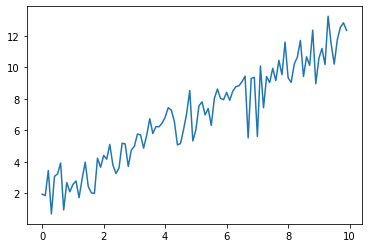

In [ ]:
x     = np.arange(0, 10, 0.1)
noise = np.random.normal(0, 1, 100)
y     = x + 2 + noise

plt.plot(x, y)

x = x.astype('float32')
y = y.astype('float32')

m:	tf.Tensor([1.0262669], shape=(1,), dtype=float32)
q:	tf.Tensor(1.813596, shape=(), dtype=float32)


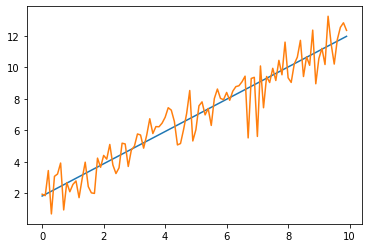

In [ ]:
reg = LinearRegression()

m, q = reg.train(x, y, learning_rate = 0.01, epochs = 1000)
clear_output()

print("m:\t" + str(m.value()))
print("q:\t" + str(q.value()))

pred = m*x + q
plt.plot(x, pred)
plt.plot(x, y)

In [ ]:
class LinearRegression:
  def __init__(self):
    self.var = tf.random.uniform(shape = [], minval=0., maxval=1.)

    self.m = tf.Variable(1., shape = tf.TensorShape(None))
    self.q = tf.Variable(self.var)

    print("Initialized LinearRegression model.")
    print("m:\t" + str(self.m))
    print("q:\t" + str(self.q))

    return 

  def train(self, X, y, learning_rate, epochs):

    if len(X.shape) == 1:
      X = tf.reshape(X, [X.shape[0], 1])

    self.m.assign([self.var]*X.shape[-1])

    for epoch in range(epochs):
      print("Epoch:\t" + str(epoch))

      self.update_weights(X, y, learning_rate)

    return (self.m, self.q)

  def predict(self, x):
    return tf.reduce_sum(self.m * x, 1) + self.q
  
  def mse(self, true, predicted):
    return tf.reduce_mean(tf.square(true-predicted))

  def update_weights(self, X, y, learning_rate):
    with tf.GradientTape(persistent = True) as g:
      loss = self.mse(y, self.predict(X))

    print("Loss:\t" + str(loss))

    dy_dm = g.gradient(loss, self.m)
    dy_dq = g.gradient(loss, self.q)

    self.m.assign_sub(learning_rate * dy_dm)
    self.q.assign_sub(learning_rate * dy_dq)

### Assignment 2: Fashion MNIST hallucination using DCGAN

- Download Fashion MNIST using tf.keras.datasets
- Create a generator model using Convolutional and Upsample2D layers
- Create a discriminator model using a simple convnet
- Create a GAN model by subclassing, taking the generator and discriminator as inputs in the
constructor
- Overload the GAN model train_step to implement adversarial training
- Visualize the generated fashion MNIST images

Loaded dataset! :)


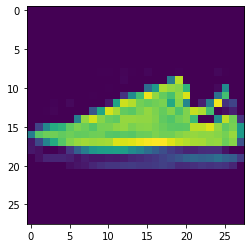

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
clear_output()
print("Loaded dataset! :)")
plt.imshow(x_train[6])

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = (x_train-127.5) / 127.5

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE  = 100

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

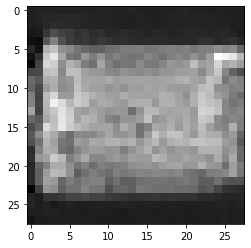

In [ ]:
gan = GAN(
    Discriminator(),
    Generator()
) 

gan(train_dataset,50)

In [ ]:
# Discriminator Model

class Discriminator():

  def __init__(self):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(7, (3,3), padding="same", input_shape = (28,28,1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(50, activation = "relu"))
    model.add(tf.keras.layers.Dense(1))

    self.model = model

  def get_loss(self, real_predictions, fake_predictions):
    real_predictions = tf.sigmoid(real_predictions)
    fake_predictions = tf.sigmoid(fake_predictions)

    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_predictions),  real_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions)

    return real_loss + fake_loss

# Generator Model

class Generator():

  def __init__(self):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, input_shape = (100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Reshape((7,7,256)))
    model.add(tf.keras.layers.Conv2DTranspose(128,(3,3), padding = "same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(64,(3,3), strides=(2,2), padding = "same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(1,(3,3), strides=(2,2), padding = "same"))

    self.model = model

  def get_loss(self, fake_predictions):
    fake_predictions = tf.sigmoid(fake_predictions)
    fake_loss        = tf.losses.binary_crossentropy(tf.ones_like(fake_predictions), fake_predictions)

    return fake_loss

class GAN(tf.keras.Model):

  def __init__(self, discriminator, generator):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator     = generator

    self.disc_optimizer = tf.optimizers.Adam(1e-3)
    self.gen_optimizer  = tf.optimizers.Adam(1e-4)

  # Training
  def call(self, dataset, epochs):
    for epoch in range(epochs):
      print("EPOCH: " + str(epoch))
      image_number = 1
      for images in dataset:
        percentage = str(round(image_number * 100 / len(dataset),2)) + "%"
        print(percentage, end=":\t")

        images = tf.cast(images, tf.dtypes.float32)
        self.train_step(images)

        image_number += 1
      
      clear_output()
    
  def train_step(self, images):
    fake_image_noise = np.random.randn(BATCH_SIZE, 100).astype("float32")
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      generated_images = self.generator.model(fake_image_noise)

      #print("1. Generated images")

      real_output = self.discriminator.model(images)
      fake_output = self.discriminator.model(generated_images)

      #print(real_output.shape)
      #print(fake_output.shape)

      #print("2. Got output from discriminator")

      gen_loss  = self.generator    .get_loss(fake_output)
      #print("3.a Got loss from generator!")

      disc_loss = self.discriminator.get_loss(real_output, fake_output)
      #print("3.b Got loss from discriminator!")

      #print("3. Got losses")

      generator_gradients     = gen_tape.gradient (gen_loss,  self.generator.model    .trainable_variables)
      discriminator_gradients = disc_tape.gradient(disc_loss, self.discriminator.model.trainable_variables)

      #print("4. Loaded gradients")

      self.gen_optimizer .apply_gradients(zip(generator_gradients,     self.generator.model.trainable_variables))
      self.disc_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.model.trainable_variables))

      #print("5. Applied gradients\n")

      print("Generator loss: " + str(round(np.mean(gen_loss), 2)), end=",\t")
      print("Discriminator loss: " + str(round(np.mean(disc_loss), 2)))